#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


## Lab. 06 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

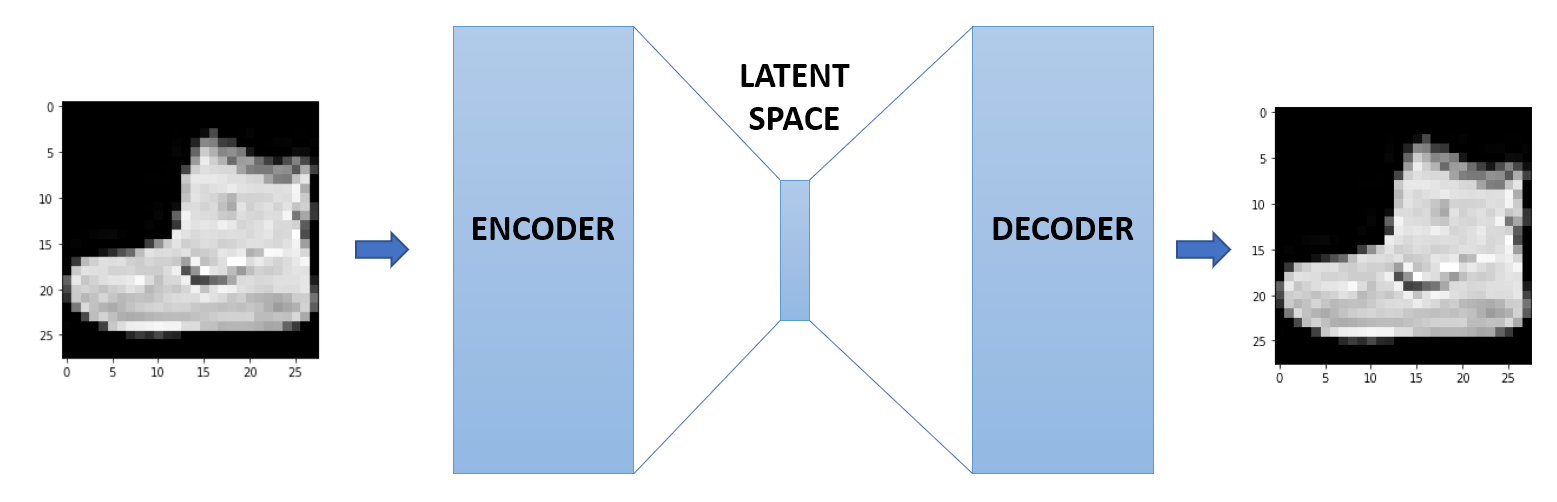

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

26422272it [14:23, 30605.35it/s]                               


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



29696it [00:01, 21221.28it/s]                           


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



4422656it [03:27, 21276.84it/s]                             


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



6144it [00:00, 14784.50it/s]                          


Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

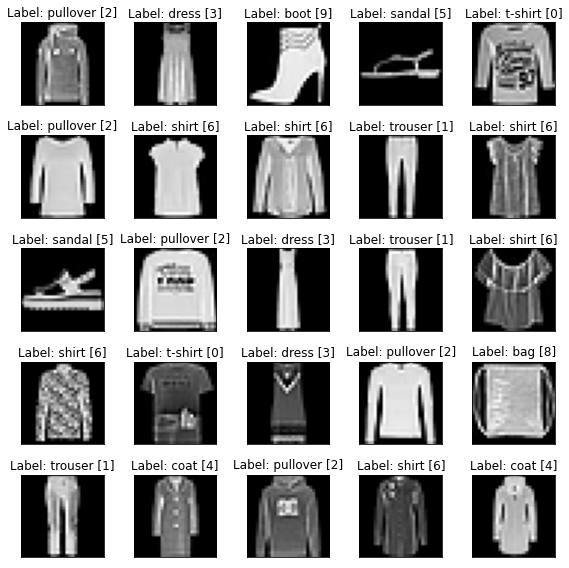

In [3]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [4]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [5]:
# check what is going on BEFORE the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x7FE967B9BDF0>, 9)
<PIL.Image.Image image mode=L size=28x28 at 0x7FE967B9BD00>
9


In [6]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [7]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [8]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

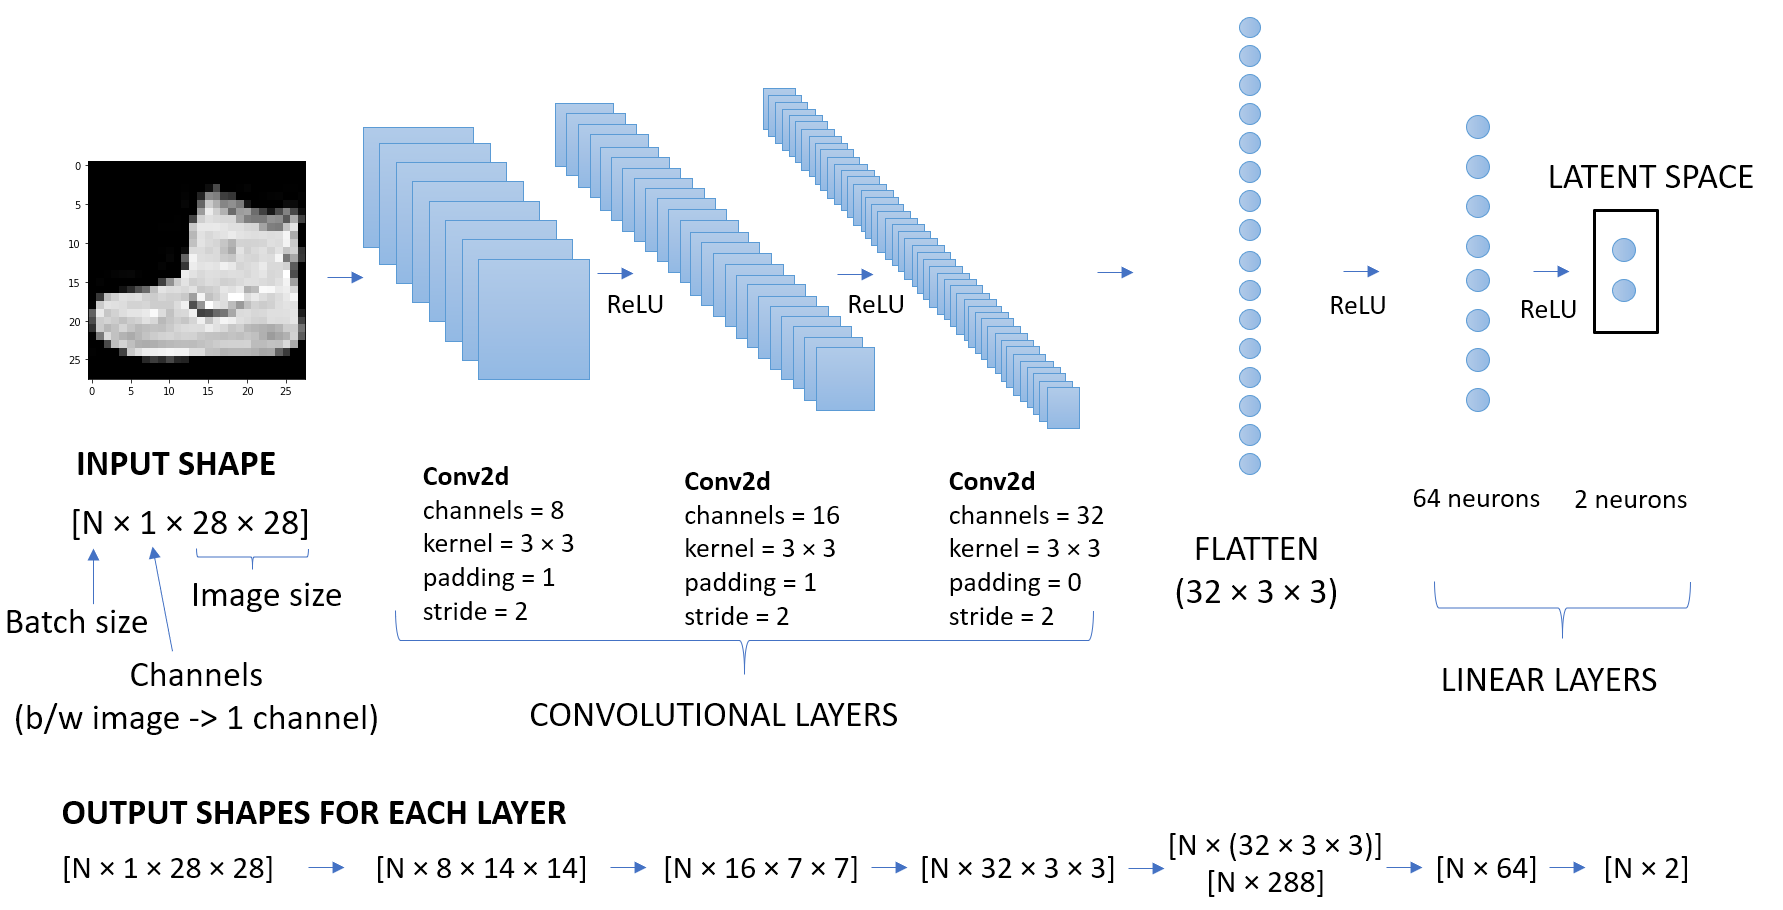

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
        )
        
        ### Flatten layer
        ### These layers can't be placed inside Sequential layers and should be
        ### applied in the forward function
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.ReLU(),
            nn.Linear(288, 64),
            nn.ReLU(),
            nn.Linear(64, encoded_space_dim),
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successful implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

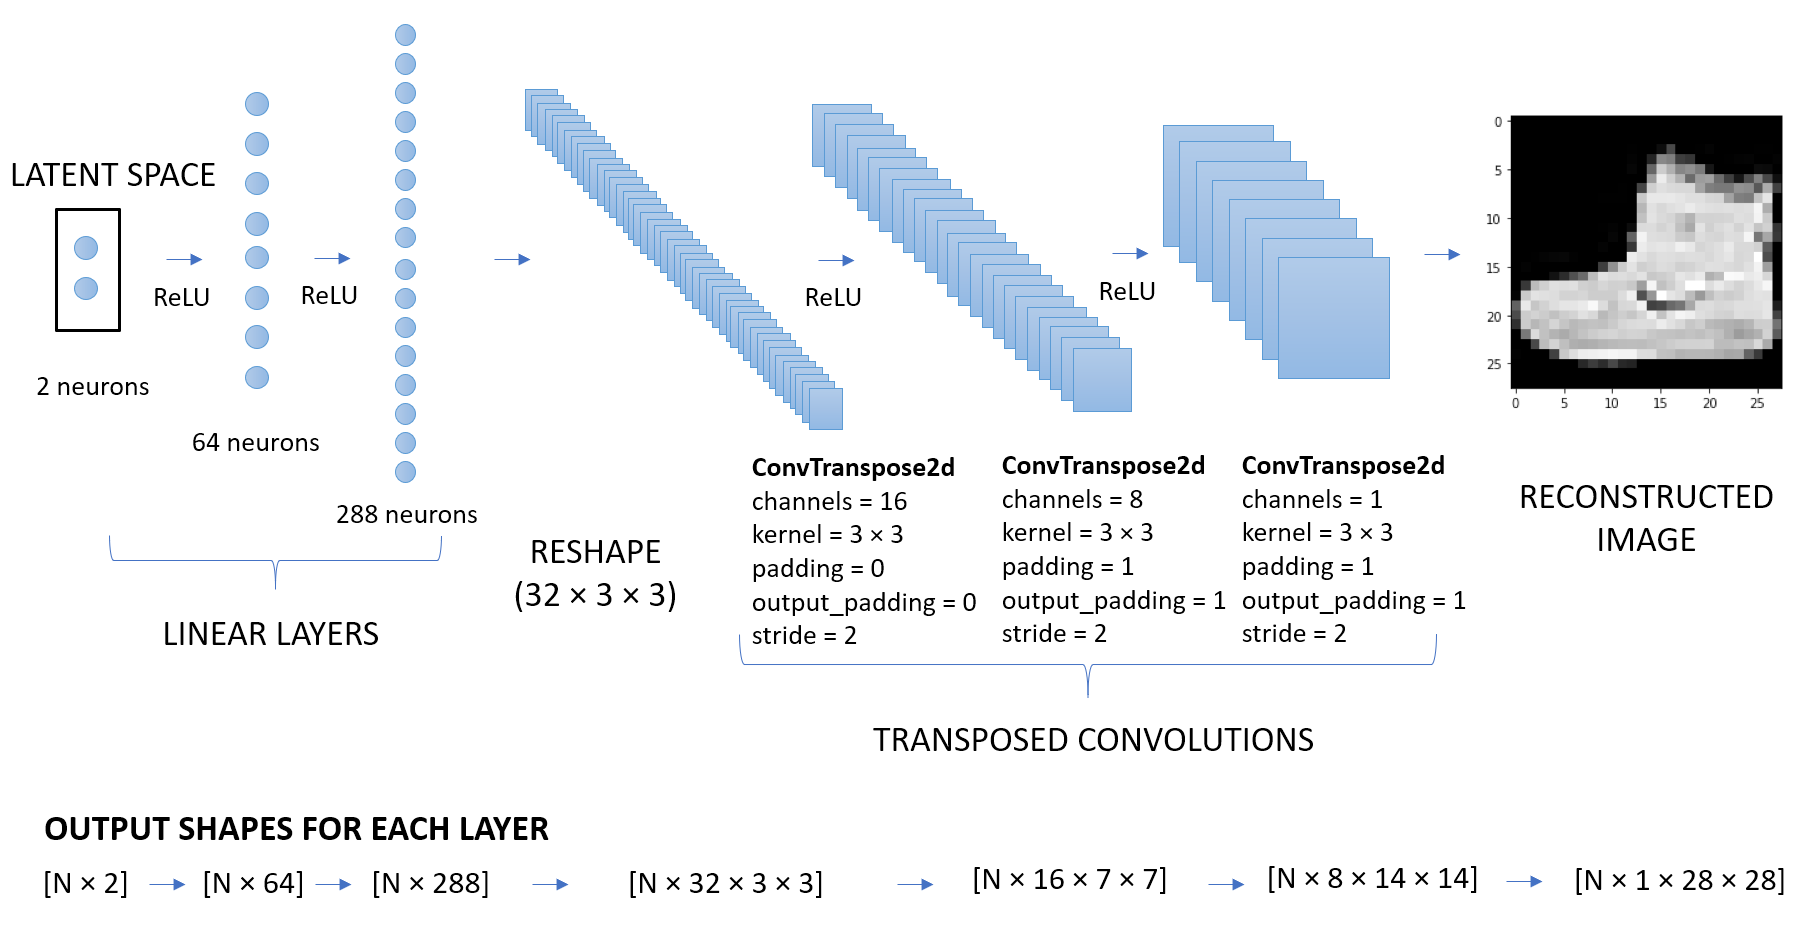

Inputs with different sizes can lead to outputs of the same size

In [10]:
input_t = torch.ones(1, 3, 5, 5)
conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2)
print(f"Input size: {input_t.shape} Output size:{conv(input_t).shape}")


input_t = torch.ones(1, 3, 6, 6)
print(f"Input size: {input_t.shape} Output size:{conv(input_t).shape}")

Input size: torch.Size([1, 3, 5, 5]) Output size:torch.Size([1, 8, 2, 2])
Input size: torch.Size([1, 3, 6, 6]) Output size:torch.Size([1, 8, 2, 2])


In the decoder the correct output size can be obtained by specifying the `output_padding` parameter

In [11]:
input_t = torch.ones(1, 8, 2, 2)
conv_zero_out_pad = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, output_padding=0)
print(f"Input size: {input_t.shape} Output size:{conv_zero_out_pad(input_t).shape}")

conv_out_pad = nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2, output_padding=1)
print(f"Input size: {input_t.shape} Output size:{conv_out_pad(input_t).shape}")

Input size: torch.Size([1, 8, 2, 2]) Output size:torch.Size([1, 3, 5, 5])
Input size: torch.Size([1, 8, 2, 2]) Output size:torch.Size([1, 3, 6, 6])


In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First convolutional layer
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0, padding=0),
            nn.ReLU(True),
            # Second convolutional layer
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, output_padding=1, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, output_padding=1, padding=1),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        return x

Initialize the two networks.

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [14]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the training loop.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [15]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [16]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    losses = []

    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: 
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
    losses = np.mean(losses)
    return losses

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [17]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10
TRAIN - EPOCH 1/10 - loss: 0.10274308919906616
VALIDATION - EPOCH 1/10 - loss: 0.05145590379834175



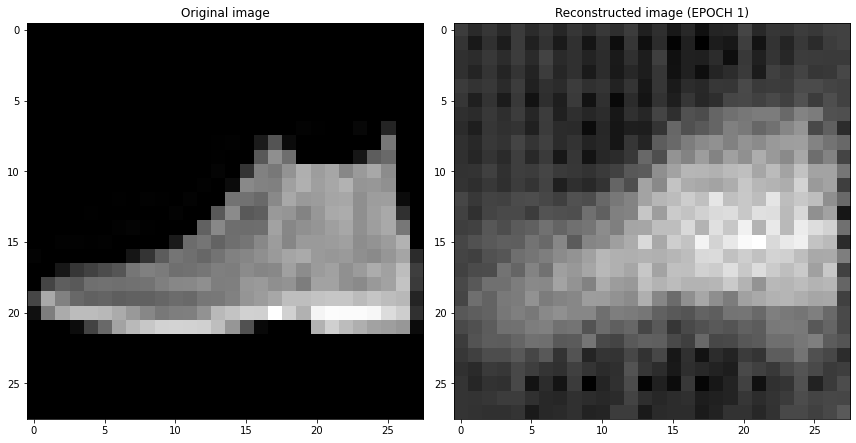

EPOCH 2/10
TRAIN - EPOCH 2/10 - loss: 0.04077212139964104
VALIDATION - EPOCH 2/10 - loss: 0.03657174110412598



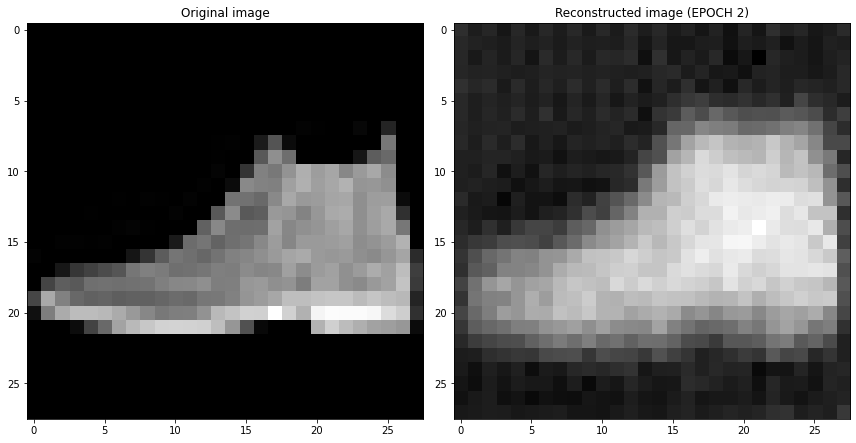

EPOCH 3/10
TRAIN - EPOCH 3/10 - loss: 0.03537213057279587
VALIDATION - EPOCH 3/10 - loss: 0.034201353788375854



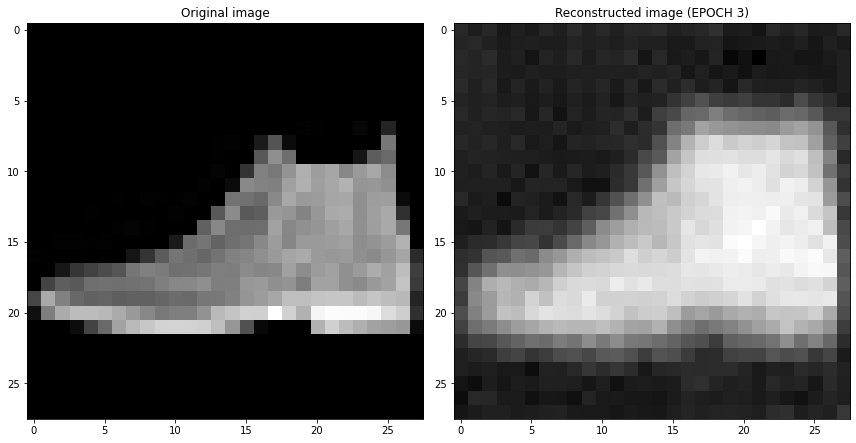

EPOCH 4/10
TRAIN - EPOCH 4/10 - loss: 0.033658452332019806
VALIDATION - EPOCH 4/10 - loss: 0.0331488773226738



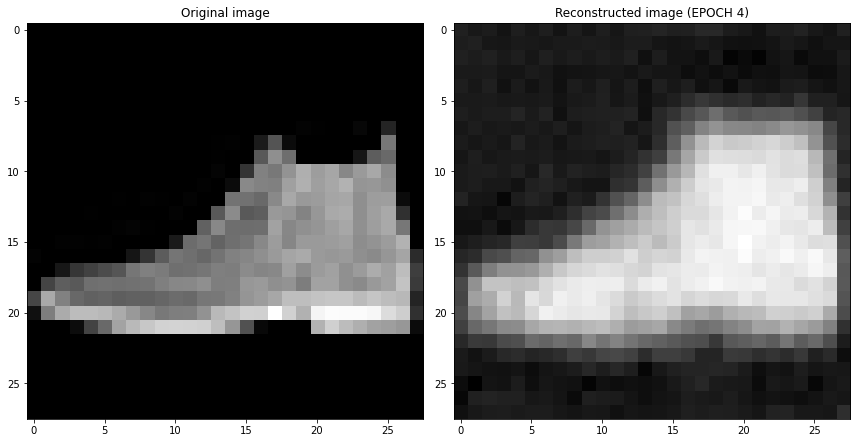

EPOCH 5/10
TRAIN - EPOCH 5/10 - loss: 0.03265644609928131
VALIDATION - EPOCH 5/10 - loss: 0.032272934913635254



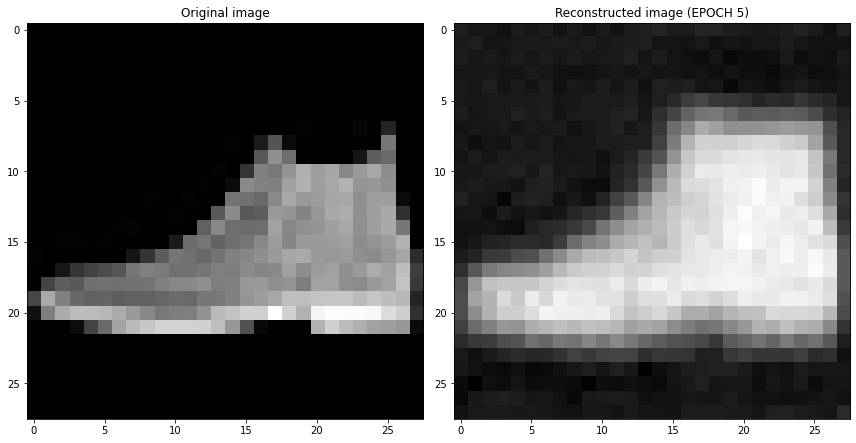

EPOCH 6/10
TRAIN - EPOCH 6/10 - loss: 0.03201599419116974
VALIDATION - EPOCH 6/10 - loss: 0.03168397769331932



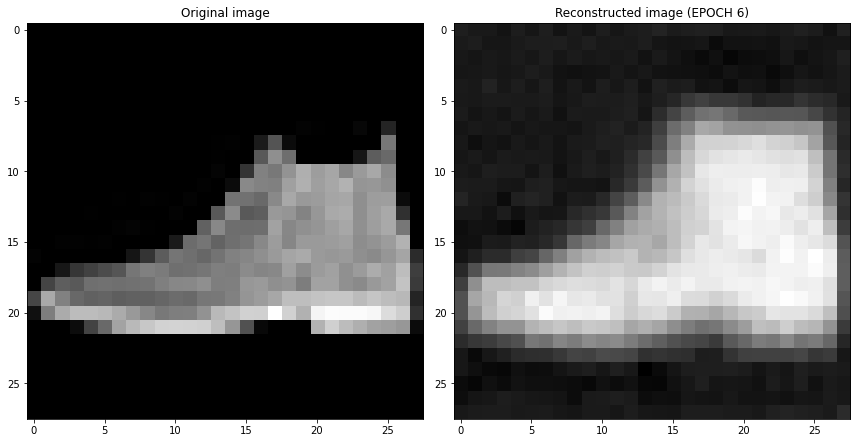

EPOCH 7/10
TRAIN - EPOCH 7/10 - loss: 0.03156668320298195
VALIDATION - EPOCH 7/10 - loss: 0.031221339479088783



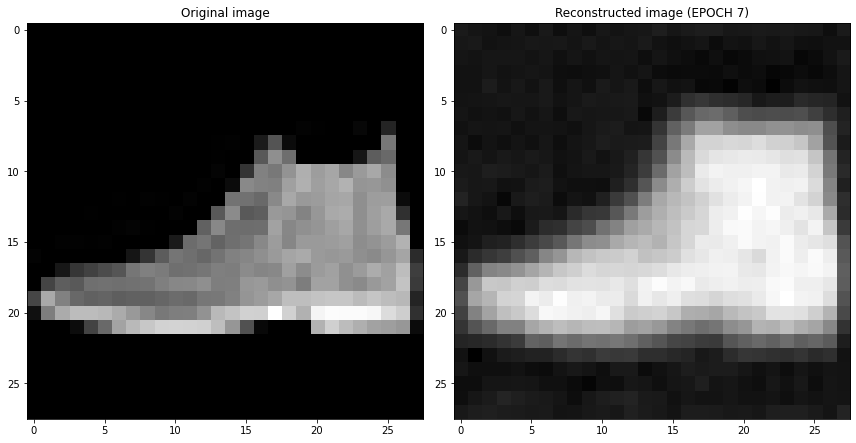

EPOCH 8/10
TRAIN - EPOCH 8/10 - loss: 0.031176133081316948
VALIDATION - EPOCH 8/10 - loss: 0.030922781676054



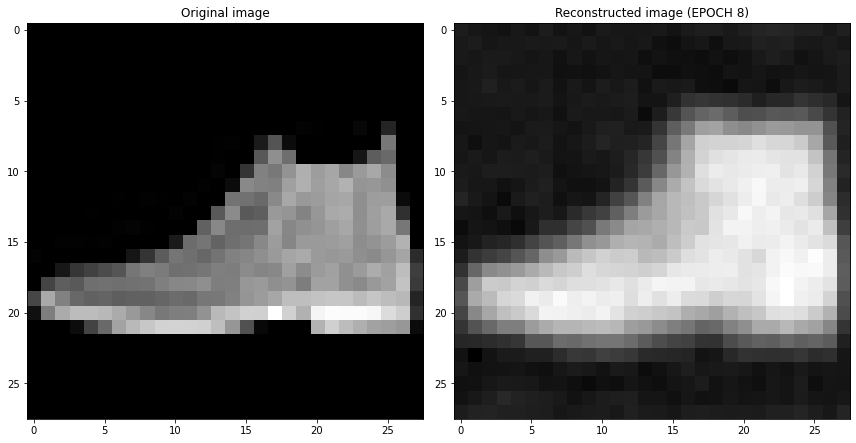

EPOCH 9/10
TRAIN - EPOCH 9/10 - loss: 0.030921489000320435
VALIDATION - EPOCH 9/10 - loss: 0.030601346865296364



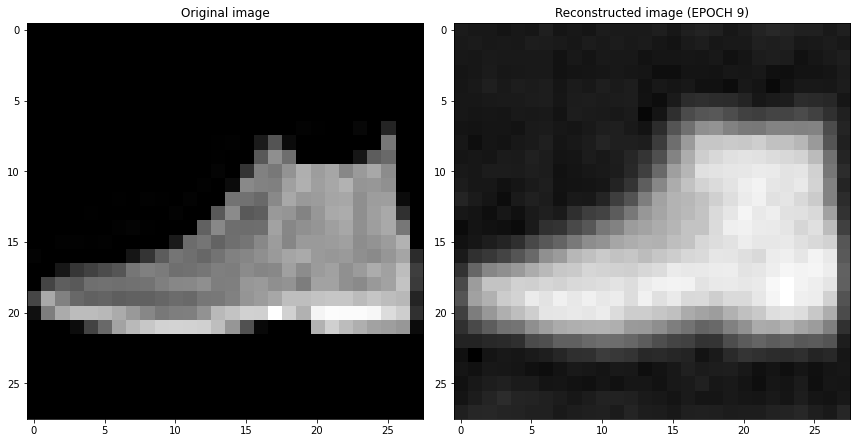

EPOCH 10/10
TRAIN - EPOCH 10/10 - loss: 0.030645573511719704
VALIDATION - EPOCH 10/10 - loss: 0.030477074906229973



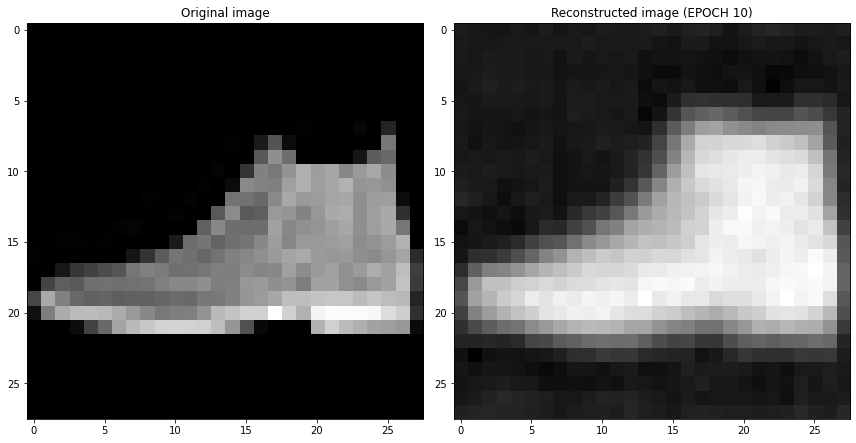

In [18]:
### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}')

    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')


    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [19]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [20]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:03<00:00, 2665.30it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [26]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,label
0,-10.740398,-1.455244,-4.775313,-11.891405,1.617639,-7.978542,9.958076,11.234191,-3.722616,0.033324,9
1,-0.621884,7.999099,-31.378242,-21.487825,2.603209,1.819320,0.100296,21.766703,-20.288002,-7.036043,2
2,5.278567,13.796862,-10.689398,-3.244893,-3.081249,7.409067,2.828089,5.361550,-13.086910,-11.414100,1
3,4.414258,9.614137,-7.730979,0.107269,-3.834297,5.102362,0.916933,3.407779,-10.014212,-8.591758,1
4,-2.144898,4.984402,-21.171690,-13.851789,-2.250317,0.430163,-0.202581,12.950916,-11.236863,-7.079361,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,-14.914117,0.515611,-12.190750,-18.420900,-3.790505,-12.309151,11.524282,15.854400,-2.314674,-5.081017,9
9996,3.551531,6.163433,-6.195720,-0.043885,-3.173459,3.647535,1.244158,2.625598,-8.360072,-5.092673,1
9997,-5.230474,6.004678,-10.831293,0.414900,-4.951648,2.634406,-1.358383,18.809446,-7.967365,-5.074161,8
9998,3.095204,11.158571,-6.320989,-1.902785,-6.511075,4.821952,4.367852,3.111711,-9.827168,-8.745226,1


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [27]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

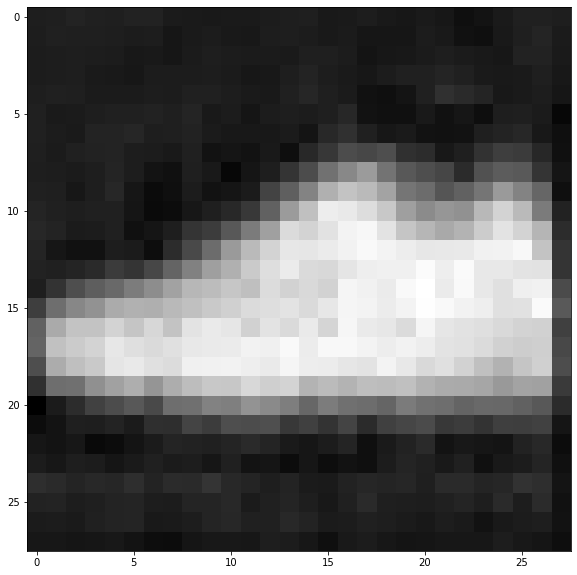

In [21]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cpu
EPOCH 1/10
TRAIN - EPOCH 1/10 - loss: 0.1503637433052063

VALIDATION - EPOCH 1/10 - loss: 0.049355026334524155



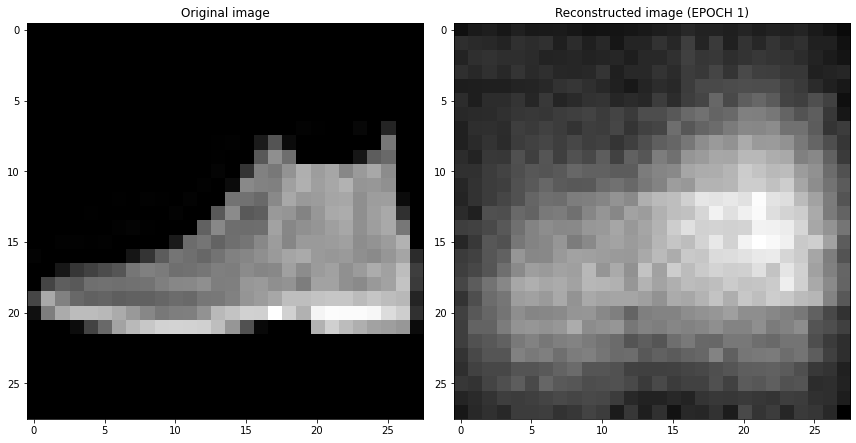

EPOCH 2/10
TRAIN - EPOCH 2/10 - loss: 0.04005401208996773

VALIDATION - EPOCH 2/10 - loss: 0.03460312262177467



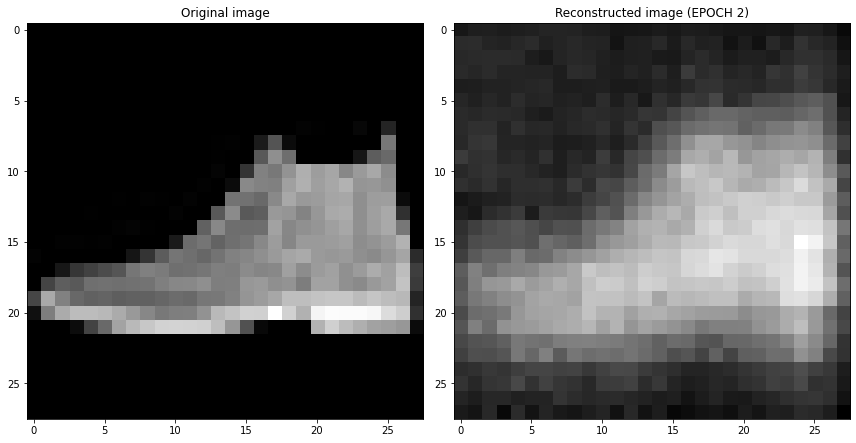

EPOCH 3/10
TRAIN - EPOCH 3/10 - loss: 0.03135393559932709

VALIDATION - EPOCH 3/10 - loss: 0.028906874358654022



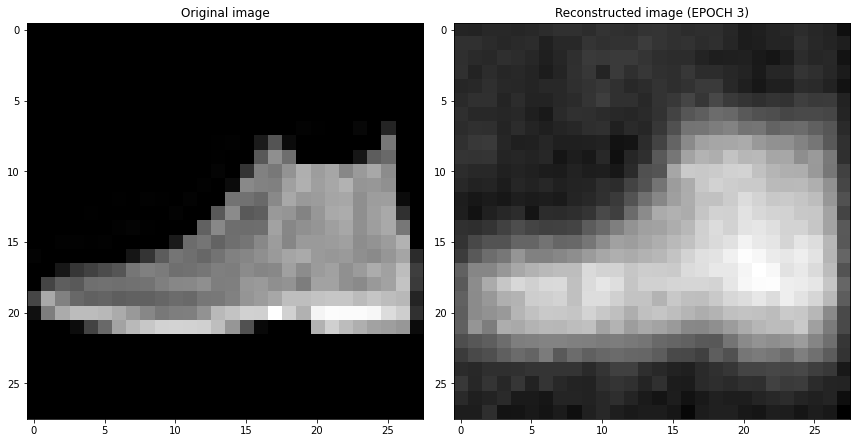

EPOCH 4/10
TRAIN - EPOCH 4/10 - loss: 0.027586983516812325

VALIDATION - EPOCH 4/10 - loss: 0.026531625539064407



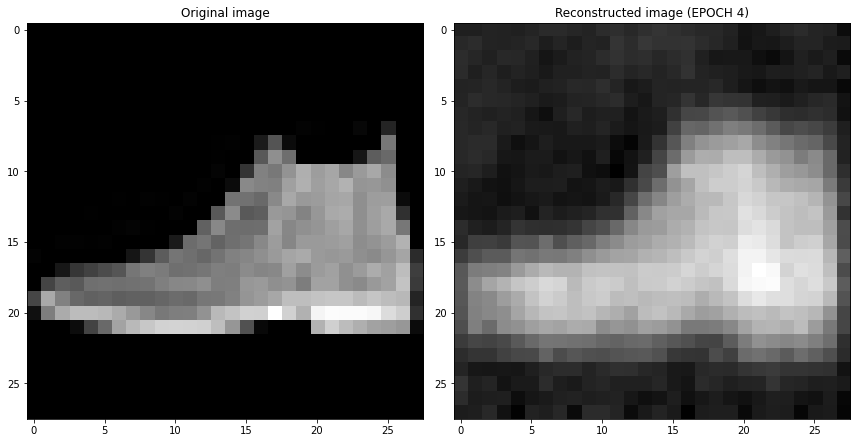

EPOCH 5/10
TRAIN - EPOCH 5/10 - loss: 0.025690443813800812

VALIDATION - EPOCH 5/10 - loss: 0.025030141696333885



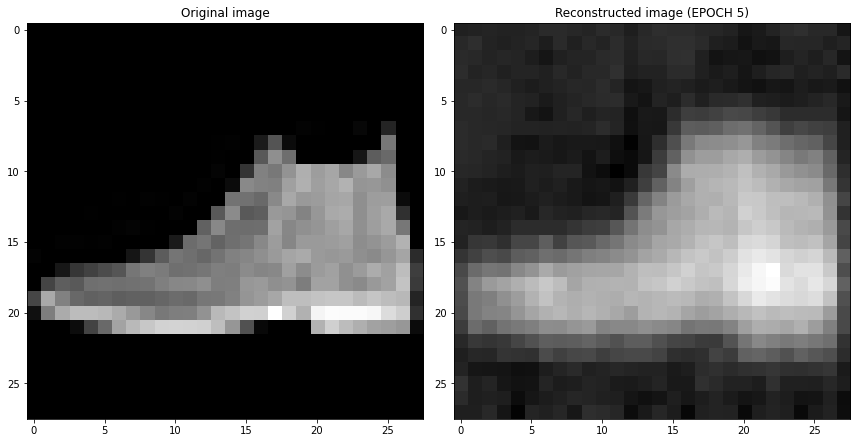

EPOCH 6/10
TRAIN - EPOCH 6/10 - loss: 0.024412764236330986

VALIDATION - EPOCH 6/10 - loss: 0.02390049770474434



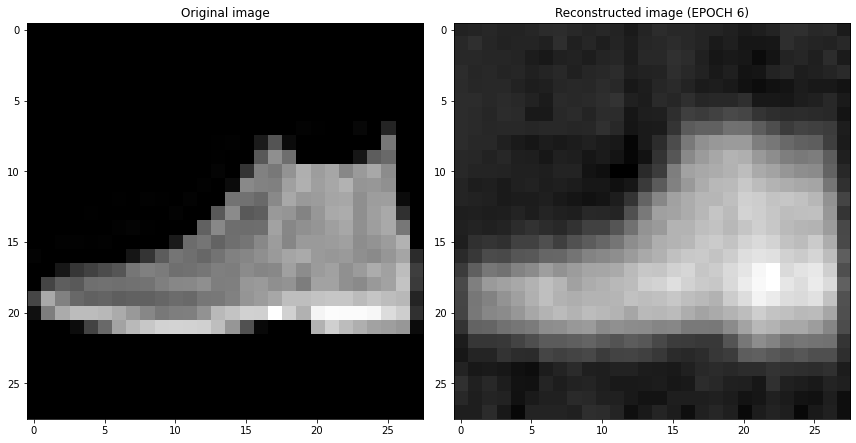

EPOCH 7/10
TRAIN - EPOCH 7/10 - loss: 0.023459700867533684

VALIDATION - EPOCH 7/10 - loss: 0.023132653906941414



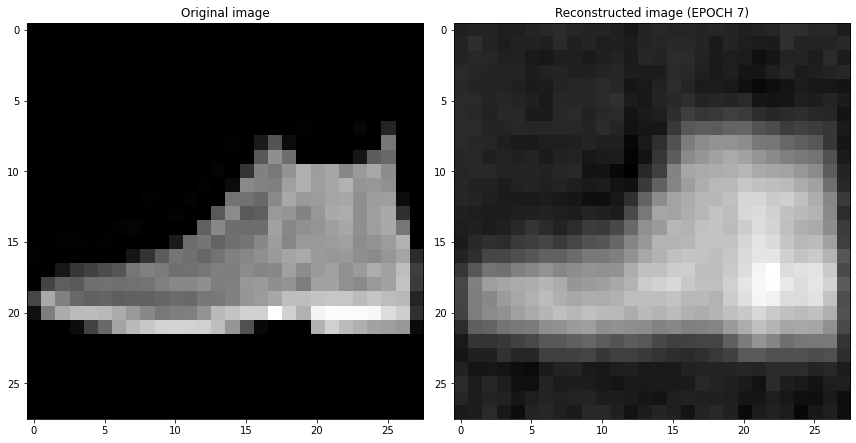

EPOCH 8/10
TRAIN - EPOCH 8/10 - loss: 0.022690480574965477

VALIDATION - EPOCH 8/10 - loss: 0.022401219233870506



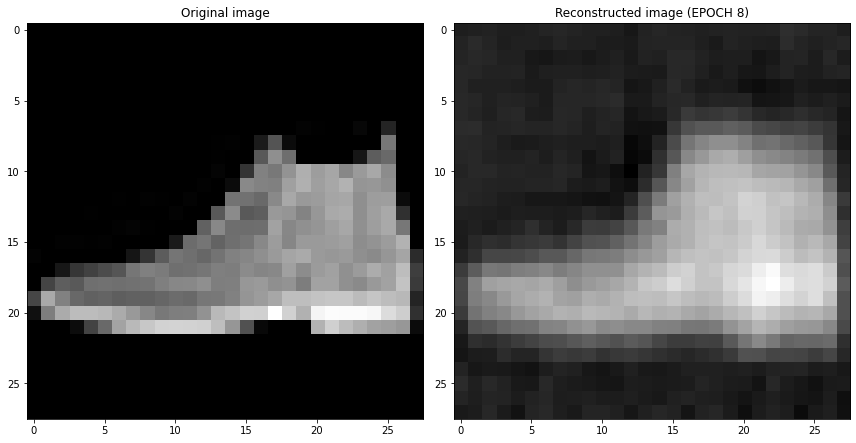

EPOCH 9/10
TRAIN - EPOCH 9/10 - loss: 0.022063007578253746

VALIDATION - EPOCH 9/10 - loss: 0.021844176575541496



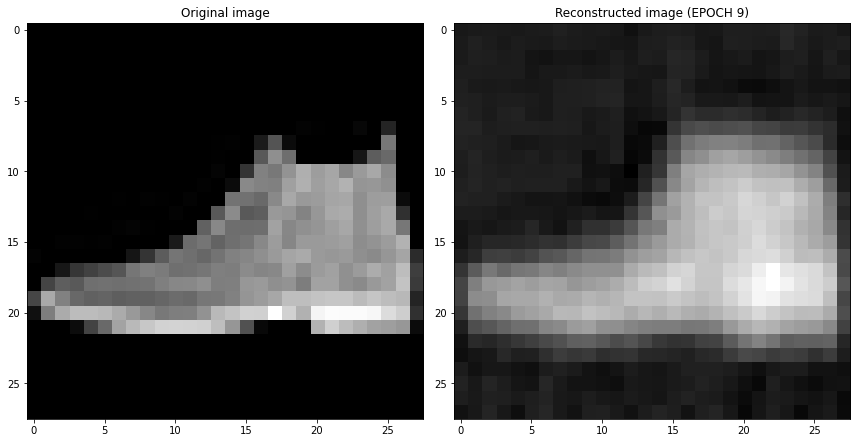

EPOCH 10/10
TRAIN - EPOCH 10/10 - loss: 0.021509969606995583

VALIDATION - EPOCH 10/10 - loss: 0.021271858364343643



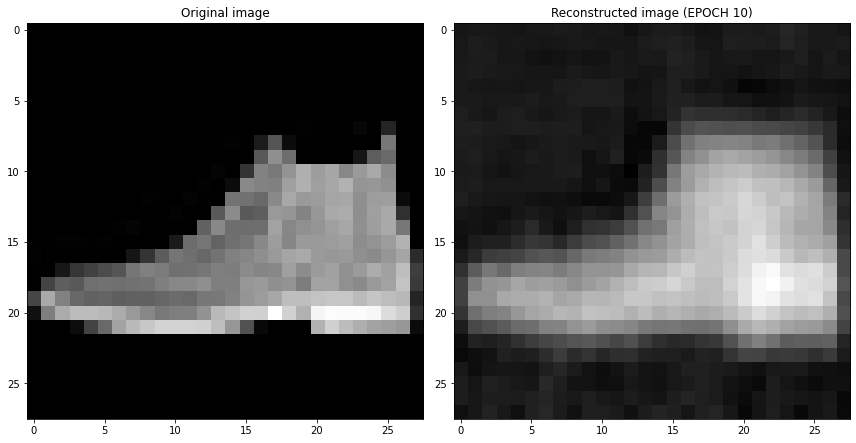

In [22]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10  # this is the only line we change!
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    print(f'TRAIN - EPOCH {epoch+1}/{num_epochs} - loss: {train_loss}\n')
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print(f'VALIDATION - EPOCH {epoch+1}/{num_epochs} - loss: {val_loss}\n')

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [23]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:03<00:00, 2593.77it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,label
0,-10.740398,-1.455244,-4.775313,-11.891405,1.617639,-7.978542,9.958076,11.234191,-3.722616,0.033324,9
1,-0.621884,7.999099,-31.378242,-21.487825,2.603209,1.819320,0.100296,21.766703,-20.288002,-7.036043,2
2,5.278567,13.796862,-10.689398,-3.244893,-3.081249,7.409067,2.828089,5.361550,-13.086910,-11.414100,1
3,4.414258,9.614137,-7.730979,0.107269,-3.834297,5.102362,0.916933,3.407779,-10.014212,-8.591758,1
4,-2.144898,4.984402,-21.171690,-13.851789,-2.250317,0.430163,-0.202581,12.950916,-11.236863,-7.079361,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,-14.914117,0.515611,-12.190750,-18.420900,-3.790505,-12.309151,11.524282,15.854400,-2.314674,-5.081017,9
9996,3.551531,6.163433,-6.195720,-0.043885,-3.173459,3.647535,1.244158,2.625598,-8.360072,-5.092673,1
9997,-5.230474,6.004678,-10.831293,0.414900,-4.951648,2.634406,-1.358383,18.809446,-7.967365,-5.074161,8
9998,3.095204,11.158571,-6.320989,-1.902785,-6.511075,4.821952,4.367852,3.111711,-9.827168,-8.745226,1


**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples[[f"Enc. Variable {i}" for i in range(encoded_space_dim)]])
encoded_samples_reduced_PCA

array([[-20.29370292,   6.88489522],
       [ 19.06219851,  10.95424701],
       [  1.47090983, -18.23557801],
       ...,
       [ -2.83334954,  -7.36836409],
       [ -6.28516796, -18.44714561],
       [-18.07744502,  -1.06892467]])

In [28]:
encoded_samples_reduced_PCA = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_PCA[:, 0],
    "Enc. Variable 1": encoded_samples_reduced_PCA[:, 1], 
    "label":encoded_samples.label}
)
px.scatter(encoded_samples_reduced_PCA, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples[[f"Enc. Variable {i}" for i in range(encoded_space_dim)]])
encoded_samples_reduced_TSNE = pd.DataFrame({
    "Enc. Variable 0": encoded_samples_reduced_TSNE[:, 0],
    "Enc. Variable 1": encoded_samples_reduced_TSNE[:, 1], 
    "label":encoded_samples.label}
)
px.scatter(encoded_samples_reduced_TSNE, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



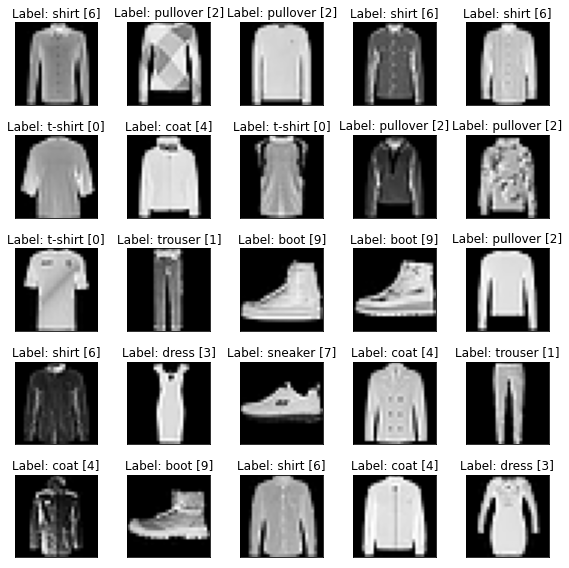

In [30]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img.permute(1,2,0).repeat(1, 1, 3)), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


# Classification from the latents
Since the latent representations produced by the encoder are usually clustered according to the different classes they can often be used as input to a classifier to solve the classification task. 

Of course it is usually better to simply train the neural network for classification if you have enough labeled data. However since assigning labels to the input samples is often very expensive in some cases you might have partially labeled datasets.

 For this reason you could first train an autoencoder to extract some discriminative features in the data and then train a simpler classifier to take these as input and to predict the class.
 
This task can be usually solved by a simpler model that has lower likelyhood to overfit than a full end-to-end model given the low data avilability.

# Simple classifier on the features produced by the encoder
Here we define a dataset that returns the original images, their representations extracted with the encoder and the label.

In [31]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class AEDataset(Dataset):

    def __init__(self, encoder, normal_dataloader, device):
        encoder = encoder.to(device)
        self.x = []
        self.y = []
        self.latents = []
        for x, y in normal_dataloader:
            self.x.append(x)
            self.y.append(y)
            x = x.to(device)
            latents = encoder(x).detach().cpu()
            self.latents.append(latents)
        
        self.x = torch.cat(self.x, axis=0)
        self.y = torch.cat(self.y, axis=0)
        self.latents = torch.cat(self.latents, axis=0)
        self.x, _, self.latents, _, self.y, _ = train_test_split(self.x, self.latents, self.y, train_size=0.01, stratify=self.y)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.latents[idx],  self.y[idx]

In [32]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [33]:
from sklearn.metrics import accuracy_score
### Set the random seed for reproducible results
torch.manual_seed(0)

model = SimpleClassifier(encoded_space_dim)
train_dataloader_latents = DataLoader(AEDataset(encoder, train_dataloader, device), batch_size=32, shuffle=True)

### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model.to(device)


### Training cycle
num_epochs = 100
val_losses_enc = []
val_accs_enc = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    model.train()
    for x, latents, y in tqdm(train_dataloader_latents):
        latents = latents.to(device)
        y = y.to(device)
        y_pred = model(latents)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Set evaluation mode
    model.eval()
    encoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, y in test_dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            y_pred = model(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(y_pred.cpu())
            conc_label.append(y)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss and accuracy
        val_loss = loss_fn(conc_out, conc_label)
        val_acc = accuracy_score(conc_label, conc_out.softmax(axis=1).argmax(axis=1))
        val_losses_enc.append(val_loss)
        val_accs_enc.append(val_acc)


    print(f'\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - loss: {val_loss} - acc {val_acc}')

Selected device: cpu
EPOCH 1/100


100%|██████████| 19/19 [00:00<00:00, 603.42it/s]


	 VALIDATION - EPOCH 1/100 - loss: 1.9927889108657837 - acc 0.2566
EPOCH 2/100


100%|██████████| 19/19 [00:00<00:00, 1104.64it/s]


	 VALIDATION - EPOCH 2/100 - loss: 1.3979109525680542 - acc 0.565
EPOCH 3/100


100%|██████████| 19/19 [00:00<00:00, 1132.90it/s]


	 VALIDATION - EPOCH 3/100 - loss: 1.1564750671386719 - acc 0.6132
EPOCH 4/100


100%|██████████| 19/19 [00:00<00:00, 1136.29it/s]


	 VALIDATION - EPOCH 4/100 - loss: 1.0470263957977295 - acc 0.6301
EPOCH 5/100


100%|██████████| 19/19 [00:00<00:00, 1161.03it/s]


	 VALIDATION - EPOCH 5/100 - loss: 0.9814543128013611 - acc 0.6461
EPOCH 6/100


100%|██████████| 19/19 [00:00<00:00, 1036.95it/s]


	 VALIDATION - EPOCH 6/100 - loss: 0.9432674646377563 - acc 0.6469
EPOCH 7/100


100%|██████████| 19/19 [00:00<00:00, 1230.57it/s]


	 VALIDATION - EPOCH 7/100 - loss: 0.9062168002128601 - acc 0.6616
EPOCH 8/100


100%|██████████| 19/19 [00:00<00:00, 1263.30it/s]


	 VALIDATION - EPOCH 8/100 - loss: 0.8871455192565918 - acc 0.6674
EPOCH 9/100


100%|██████████| 19/19 [00:00<00:00, 1240.69it/s]


	 VALIDATION - EPOCH 9/100 - loss: 0.87112957239151 - acc 0.6699
EPOCH 10/100


100%|██████████| 19/19 [00:00<00:00, 963.19it/s]


	 VALIDATION - EPOCH 10/100 - loss: 0.8508175611495972 - acc 0.6866
EPOCH 11/100


100%|██████████| 19/19 [00:00<00:00, 1167.29it/s]


	 VALIDATION - EPOCH 11/100 - loss: 0.835795521736145 - acc 0.6843
EPOCH 12/100


100%|██████████| 19/19 [00:00<00:00, 1080.96it/s]


	 VALIDATION - EPOCH 12/100 - loss: 0.8270326256752014 - acc 0.6918
EPOCH 13/100


100%|██████████| 19/19 [00:00<00:00, 1268.37it/s]


	 VALIDATION - EPOCH 13/100 - loss: 0.8124264478683472 - acc 0.6959
EPOCH 14/100


100%|██████████| 19/19 [00:00<00:00, 1199.20it/s]


	 VALIDATION - EPOCH 14/100 - loss: 0.8075119256973267 - acc 0.6988
EPOCH 15/100


100%|██████████| 19/19 [00:00<00:00, 1270.58it/s]


	 VALIDATION - EPOCH 15/100 - loss: 0.7971684336662292 - acc 0.7033
EPOCH 16/100


100%|██████████| 19/19 [00:00<00:00, 1191.37it/s]


	 VALIDATION - EPOCH 16/100 - loss: 0.7929707765579224 - acc 0.7075
EPOCH 17/100


100%|██████████| 19/19 [00:00<00:00, 1264.09it/s]


	 VALIDATION - EPOCH 17/100 - loss: 0.7882632613182068 - acc 0.7126
EPOCH 18/100


100%|██████████| 19/19 [00:00<00:00, 1261.62it/s]


	 VALIDATION - EPOCH 18/100 - loss: 0.7809427380561829 - acc 0.7058
EPOCH 19/100


100%|██████████| 19/19 [00:00<00:00, 985.53it/s]


	 VALIDATION - EPOCH 19/100 - loss: 0.7769007086753845 - acc 0.7106
EPOCH 20/100


100%|██████████| 19/19 [00:00<00:00, 1236.51it/s]


	 VALIDATION - EPOCH 20/100 - loss: 0.7723004817962646 - acc 0.7176
EPOCH 21/100


100%|██████████| 19/19 [00:00<00:00, 1199.80it/s]


	 VALIDATION - EPOCH 21/100 - loss: 0.7669178247451782 - acc 0.7163
EPOCH 22/100


100%|██████████| 19/19 [00:00<00:00, 1240.45it/s]


	 VALIDATION - EPOCH 22/100 - loss: 0.7671898007392883 - acc 0.7159
EPOCH 23/100


100%|██████████| 19/19 [00:00<00:00, 1227.80it/s]


	 VALIDATION - EPOCH 23/100 - loss: 0.7722116708755493 - acc 0.7122
EPOCH 24/100


100%|██████████| 19/19 [00:00<00:00, 1032.05it/s]


	 VALIDATION - EPOCH 24/100 - loss: 0.7600677013397217 - acc 0.7165
EPOCH 25/100


100%|██████████| 19/19 [00:00<00:00, 1110.01it/s]


	 VALIDATION - EPOCH 25/100 - loss: 0.7626039981842041 - acc 0.7154
EPOCH 26/100


100%|██████████| 19/19 [00:00<00:00, 1224.76it/s]


	 VALIDATION - EPOCH 26/100 - loss: 0.7595170140266418 - acc 0.7188
EPOCH 27/100


100%|██████████| 19/19 [00:00<00:00, 1206.52it/s]


	 VALIDATION - EPOCH 27/100 - loss: 0.7525390386581421 - acc 0.7192
EPOCH 28/100


100%|██████████| 19/19 [00:00<00:00, 1135.55it/s]


	 VALIDATION - EPOCH 28/100 - loss: 0.7513067722320557 - acc 0.7201
EPOCH 29/100


100%|██████████| 19/19 [00:00<00:00, 1195.35it/s]


	 VALIDATION - EPOCH 29/100 - loss: 0.7713046669960022 - acc 0.7105
EPOCH 30/100


100%|██████████| 19/19 [00:00<00:00, 1310.42it/s]


	 VALIDATION - EPOCH 30/100 - loss: 0.7465695142745972 - acc 0.7249
EPOCH 31/100


100%|██████████| 19/19 [00:00<00:00, 1275.44it/s]


	 VALIDATION - EPOCH 31/100 - loss: 0.7468011975288391 - acc 0.7245
EPOCH 32/100


100%|██████████| 19/19 [00:00<00:00, 1109.48it/s]


	 VALIDATION - EPOCH 32/100 - loss: 0.7552759051322937 - acc 0.7182
EPOCH 33/100


100%|██████████| 19/19 [00:00<00:00, 1242.41it/s]


	 VALIDATION - EPOCH 33/100 - loss: 0.7386032938957214 - acc 0.7276
EPOCH 34/100


100%|██████████| 19/19 [00:00<00:00, 1306.55it/s]


	 VALIDATION - EPOCH 34/100 - loss: 0.7471172213554382 - acc 0.7191
EPOCH 35/100


100%|██████████| 19/19 [00:00<00:00, 1194.60it/s]


	 VALIDATION - EPOCH 35/100 - loss: 0.7442312240600586 - acc 0.7208
EPOCH 36/100


100%|██████████| 19/19 [00:00<00:00, 1230.55it/s]


	 VALIDATION - EPOCH 36/100 - loss: 0.7374439239501953 - acc 0.7268
EPOCH 37/100


100%|██████████| 19/19 [00:00<00:00, 1223.35it/s]


	 VALIDATION - EPOCH 37/100 - loss: 0.7373349070549011 - acc 0.7247
EPOCH 38/100


100%|██████████| 19/19 [00:00<00:00, 1202.01it/s]


	 VALIDATION - EPOCH 38/100 - loss: 0.7364484667778015 - acc 0.7255
EPOCH 39/100


100%|██████████| 19/19 [00:00<00:00, 1204.51it/s]


	 VALIDATION - EPOCH 39/100 - loss: 0.7353207468986511 - acc 0.727
EPOCH 40/100


100%|██████████| 19/19 [00:00<00:00, 1203.68it/s]


	 VALIDATION - EPOCH 40/100 - loss: 0.7341058254241943 - acc 0.7271
EPOCH 41/100


100%|██████████| 19/19 [00:00<00:00, 1164.73it/s]


	 VALIDATION - EPOCH 41/100 - loss: 0.7399685978889465 - acc 0.7178
EPOCH 42/100


100%|██████████| 19/19 [00:00<00:00, 1164.01it/s]


	 VALIDATION - EPOCH 42/100 - loss: 0.7346020340919495 - acc 0.7265
EPOCH 43/100


100%|██████████| 19/19 [00:00<00:00, 1182.91it/s]


	 VALIDATION - EPOCH 43/100 - loss: 0.7265318632125854 - acc 0.7305
EPOCH 44/100


100%|██████████| 19/19 [00:00<00:00, 818.07it/s]


	 VALIDATION - EPOCH 44/100 - loss: 0.7387903928756714 - acc 0.7213
EPOCH 45/100


100%|██████████| 19/19 [00:00<00:00, 96.47it/s]


	 VALIDATION - EPOCH 45/100 - loss: 0.7282220125198364 - acc 0.7301
EPOCH 46/100


100%|██████████| 19/19 [00:00<00:00, 1157.05it/s]


	 VALIDATION - EPOCH 46/100 - loss: 0.7313494086265564 - acc 0.7272
EPOCH 47/100


100%|██████████| 19/19 [00:00<00:00, 737.23it/s]


	 VALIDATION - EPOCH 47/100 - loss: 0.7270044684410095 - acc 0.7262
EPOCH 48/100


100%|██████████| 19/19 [00:00<00:00, 637.46it/s]


	 VALIDATION - EPOCH 48/100 - loss: 0.727858304977417 - acc 0.725
EPOCH 49/100


100%|██████████| 19/19 [00:00<00:00, 857.29it/s]


	 VALIDATION - EPOCH 49/100 - loss: 0.7258704304695129 - acc 0.7269
EPOCH 50/100


100%|██████████| 19/19 [00:00<00:00, 1064.79it/s]


	 VALIDATION - EPOCH 50/100 - loss: 0.725297212600708 - acc 0.7275
EPOCH 51/100


100%|██████████| 19/19 [00:00<00:00, 1138.81it/s]


	 VALIDATION - EPOCH 51/100 - loss: 0.725387454032898 - acc 0.7254
EPOCH 52/100


100%|██████████| 19/19 [00:00<00:00, 861.94it/s]


	 VALIDATION - EPOCH 52/100 - loss: 0.7252160310745239 - acc 0.7279
EPOCH 53/100


100%|██████████| 19/19 [00:00<00:00, 227.14it/s]


	 VALIDATION - EPOCH 53/100 - loss: 0.7212043404579163 - acc 0.7305
EPOCH 54/100


100%|██████████| 19/19 [00:00<00:00, 632.34it/s]


	 VALIDATION - EPOCH 54/100 - loss: 0.721917450428009 - acc 0.7273
EPOCH 55/100


100%|██████████| 19/19 [00:00<00:00, 424.77it/s]


	 VALIDATION - EPOCH 55/100 - loss: 0.7225033044815063 - acc 0.7298
EPOCH 56/100


100%|██████████| 19/19 [00:00<00:00, 750.18it/s]


	 VALIDATION - EPOCH 56/100 - loss: 0.7226993441581726 - acc 0.7268
EPOCH 57/100


100%|██████████| 19/19 [00:00<00:00, 727.78it/s]


	 VALIDATION - EPOCH 57/100 - loss: 0.7227747440338135 - acc 0.7287
EPOCH 58/100


100%|██████████| 19/19 [00:00<00:00, 941.48it/s]


	 VALIDATION - EPOCH 58/100 - loss: 0.7286423444747925 - acc 0.7234
EPOCH 59/100


100%|██████████| 19/19 [00:00<00:00, 1276.78it/s]


	 VALIDATION - EPOCH 59/100 - loss: 0.7201247811317444 - acc 0.7381
EPOCH 60/100


100%|██████████| 19/19 [00:00<00:00, 1261.44it/s]


	 VALIDATION - EPOCH 60/100 - loss: 0.7268995046615601 - acc 0.7241
EPOCH 61/100


100%|██████████| 19/19 [00:00<00:00, 1225.25it/s]


	 VALIDATION - EPOCH 61/100 - loss: 0.7194571495056152 - acc 0.7309
EPOCH 62/100


100%|██████████| 19/19 [00:00<00:00, 1297.89it/s]


	 VALIDATION - EPOCH 62/100 - loss: 0.7177110910415649 - acc 0.7365
EPOCH 63/100


100%|██████████| 19/19 [00:00<00:00, 1246.39it/s]


	 VALIDATION - EPOCH 63/100 - loss: 0.7203078269958496 - acc 0.7368
EPOCH 64/100


100%|██████████| 19/19 [00:00<00:00, 692.02it/s]


	 VALIDATION - EPOCH 64/100 - loss: 0.7170774340629578 - acc 0.7376
EPOCH 65/100


100%|██████████| 19/19 [00:00<00:00, 1159.44it/s]


	 VALIDATION - EPOCH 65/100 - loss: 0.7251880168914795 - acc 0.7268
EPOCH 66/100


100%|██████████| 19/19 [00:00<00:00, 1002.22it/s]


	 VALIDATION - EPOCH 66/100 - loss: 0.7183579802513123 - acc 0.7405
EPOCH 67/100


100%|██████████| 19/19 [00:00<00:00, 1237.07it/s]


	 VALIDATION - EPOCH 67/100 - loss: 0.7286400198936462 - acc 0.7251
EPOCH 68/100


100%|██████████| 19/19 [00:00<00:00, 967.60it/s]


	 VALIDATION - EPOCH 68/100 - loss: 0.7214155793190002 - acc 0.7294
EPOCH 69/100


100%|██████████| 19/19 [00:00<00:00, 599.75it/s]


	 VALIDATION - EPOCH 69/100 - loss: 0.7169985771179199 - acc 0.7343
EPOCH 70/100


100%|██████████| 19/19 [00:00<00:00, 736.67it/s]


	 VALIDATION - EPOCH 70/100 - loss: 0.7312317490577698 - acc 0.7317
EPOCH 71/100


100%|██████████| 19/19 [00:00<00:00, 891.81it/s]


	 VALIDATION - EPOCH 71/100 - loss: 0.714545488357544 - acc 0.7378
EPOCH 72/100


100%|██████████| 19/19 [00:00<00:00, 977.48it/s]


	 VALIDATION - EPOCH 72/100 - loss: 0.7149699926376343 - acc 0.7344
EPOCH 73/100


100%|██████████| 19/19 [00:00<00:00, 256.62it/s]


	 VALIDATION - EPOCH 73/100 - loss: 0.715623676776886 - acc 0.7384
EPOCH 74/100


100%|██████████| 19/19 [00:00<00:00, 1080.33it/s]


	 VALIDATION - EPOCH 74/100 - loss: 0.7221801280975342 - acc 0.7307
EPOCH 75/100


100%|██████████| 19/19 [00:00<00:00, 1301.37it/s]


	 VALIDATION - EPOCH 75/100 - loss: 0.712020754814148 - acc 0.7403
EPOCH 76/100


100%|██████████| 19/19 [00:00<00:00, 1210.40it/s]


	 VALIDATION - EPOCH 76/100 - loss: 0.7118358612060547 - acc 0.7391
EPOCH 77/100


100%|██████████| 19/19 [00:00<00:00, 1196.63it/s]


	 VALIDATION - EPOCH 77/100 - loss: 0.7121633887290955 - acc 0.7416
EPOCH 78/100


100%|██████████| 19/19 [00:00<00:00, 1134.19it/s]


	 VALIDATION - EPOCH 78/100 - loss: 0.7229852080345154 - acc 0.7282
EPOCH 79/100


100%|██████████| 19/19 [00:00<00:00, 1112.00it/s]


	 VALIDATION - EPOCH 79/100 - loss: 0.7262565493583679 - acc 0.73
EPOCH 80/100


100%|██████████| 19/19 [00:00<00:00, 692.85it/s]


	 VALIDATION - EPOCH 80/100 - loss: 0.712838888168335 - acc 0.7416
EPOCH 81/100


100%|██████████| 19/19 [00:00<00:00, 829.66it/s]


	 VALIDATION - EPOCH 81/100 - loss: 0.7182649374008179 - acc 0.7309
EPOCH 82/100


100%|██████████| 19/19 [00:00<00:00, 578.30it/s]


	 VALIDATION - EPOCH 82/100 - loss: 0.7120350003242493 - acc 0.7388
EPOCH 83/100


100%|██████████| 19/19 [00:00<00:00, 363.23it/s]


	 VALIDATION - EPOCH 83/100 - loss: 0.7156999707221985 - acc 0.7374
EPOCH 84/100


100%|██████████| 19/19 [00:00<00:00, 324.12it/s]


	 VALIDATION - EPOCH 84/100 - loss: 0.7177284955978394 - acc 0.7284
EPOCH 85/100


100%|██████████| 19/19 [00:00<00:00, 903.51it/s]


	 VALIDATION - EPOCH 85/100 - loss: 0.7203692197799683 - acc 0.7308
EPOCH 86/100


100%|██████████| 19/19 [00:00<00:00, 1124.72it/s]


	 VALIDATION - EPOCH 86/100 - loss: 0.7257799506187439 - acc 0.7303
EPOCH 87/100


100%|██████████| 19/19 [00:00<00:00, 1021.55it/s]


	 VALIDATION - EPOCH 87/100 - loss: 0.7134254574775696 - acc 0.7461
EPOCH 88/100


100%|██████████| 19/19 [00:00<00:00, 773.26it/s]


	 VALIDATION - EPOCH 88/100 - loss: 0.7156758308410645 - acc 0.7322
EPOCH 89/100


100%|██████████| 19/19 [00:00<00:00, 1218.25it/s]


	 VALIDATION - EPOCH 89/100 - loss: 0.7146267294883728 - acc 0.7377
EPOCH 90/100


100%|██████████| 19/19 [00:00<00:00, 1239.22it/s]


	 VALIDATION - EPOCH 90/100 - loss: 0.7120882272720337 - acc 0.742
EPOCH 91/100


100%|██████████| 19/19 [00:00<00:00, 1207.20it/s]


	 VALIDATION - EPOCH 91/100 - loss: 0.7103950381278992 - acc 0.7449
EPOCH 92/100


100%|██████████| 19/19 [00:00<00:00, 1215.61it/s]


	 VALIDATION - EPOCH 92/100 - loss: 0.7289539575576782 - acc 0.7235
EPOCH 93/100


100%|██████████| 19/19 [00:00<00:00, 1263.71it/s]


	 VALIDATION - EPOCH 93/100 - loss: 0.7149433493614197 - acc 0.7467
EPOCH 94/100


100%|██████████| 19/19 [00:00<00:00, 1234.88it/s]


	 VALIDATION - EPOCH 94/100 - loss: 0.7118570804595947 - acc 0.7354
EPOCH 95/100


100%|██████████| 19/19 [00:00<00:00, 1247.62it/s]


	 VALIDATION - EPOCH 95/100 - loss: 0.7162224054336548 - acc 0.7353
EPOCH 96/100


100%|██████████| 19/19 [00:00<00:00, 1030.66it/s]


	 VALIDATION - EPOCH 96/100 - loss: 0.7085804343223572 - acc 0.7445
EPOCH 97/100


100%|██████████| 19/19 [00:00<00:00, 1143.90it/s]


	 VALIDATION - EPOCH 97/100 - loss: 0.7115021347999573 - acc 0.7384
EPOCH 98/100


100%|██████████| 19/19 [00:00<00:00, 1061.82it/s]


	 VALIDATION - EPOCH 98/100 - loss: 0.7284547090530396 - acc 0.7329
EPOCH 99/100


100%|██████████| 19/19 [00:00<00:00, 1232.34it/s]


	 VALIDATION - EPOCH 99/100 - loss: 0.7114426493644714 - acc 0.7364
EPOCH 100/100


100%|██████████| 19/19 [00:00<00:00, 1127.26it/s]


	 VALIDATION - EPOCH 100/100 - loss: 0.7169299721717834 - acc 0.7351


In [34]:
class FullClassifier(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3 * 3 * 32, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        x = self.classifier(x)
        return x

In [35]:
### Set the random seed for reproducible results
torch.manual_seed(0)

model = FullClassifier(encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer
lr = 5e-4 # Learning rate
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model.to(device)

val_losses_full = []
val_accs_full = []
### Training cycle
num_epochs = 100
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    model.train()
    for x, _, y in tqdm(train_dataloader_latents):
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Set evaluation mode
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, y in test_dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Perform prediction
            y_pred = model(image_batch)
            # Append the network output and the labels to the lists
            conc_out.append(y_pred.cpu())
            conc_label.append(y)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss and accuracy
        val_loss = loss_fn(conc_out, conc_label)
        val_acc = accuracy_score(conc_label, conc_out.softmax(axis=1).argmax(axis=1))
        val_losses_full.append(val_loss)
        val_accs_full.append(val_acc)
    ### Training (use the training function)
    print(f'\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - loss: {val_loss} - acc {val_acc}')

Selected device: cpu
EPOCH 1/100


100%|██████████| 19/19 [00:00<00:00, 247.02it/s]


	 VALIDATION - EPOCH 1/100 - loss: 2.300025701522827 - acc 0.1
EPOCH 2/100


100%|██████████| 19/19 [00:00<00:00, 313.06it/s]


	 VALIDATION - EPOCH 2/100 - loss: 2.271315336227417 - acc 0.1717
EPOCH 3/100


100%|██████████| 19/19 [00:00<00:00, 284.09it/s]


	 VALIDATION - EPOCH 3/100 - loss: 2.082589864730835 - acc 0.23
EPOCH 4/100


100%|██████████| 19/19 [00:00<00:00, 215.49it/s]


	 VALIDATION - EPOCH 4/100 - loss: 1.615431308746338 - acc 0.3304
EPOCH 5/100


100%|██████████| 19/19 [00:00<00:00, 277.40it/s]


	 VALIDATION - EPOCH 5/100 - loss: 1.249047040939331 - acc 0.4977
EPOCH 6/100


100%|██████████| 19/19 [00:00<00:00, 276.07it/s]


	 VALIDATION - EPOCH 6/100 - loss: 1.103085994720459 - acc 0.5173
EPOCH 7/100


100%|██████████| 19/19 [00:00<00:00, 253.53it/s]


	 VALIDATION - EPOCH 7/100 - loss: 1.0762324333190918 - acc 0.5642
EPOCH 8/100


100%|██████████| 19/19 [00:00<00:00, 212.89it/s]


	 VALIDATION - EPOCH 8/100 - loss: 1.026474952697754 - acc 0.5682
EPOCH 9/100


100%|██████████| 19/19 [00:00<00:00, 274.46it/s]


	 VALIDATION - EPOCH 9/100 - loss: 0.9640743136405945 - acc 0.6249
EPOCH 10/100


100%|██████████| 19/19 [00:00<00:00, 248.91it/s]


	 VALIDATION - EPOCH 10/100 - loss: 0.9790433645248413 - acc 0.6201
EPOCH 11/100


100%|██████████| 19/19 [00:00<00:00, 288.56it/s]


	 VALIDATION - EPOCH 11/100 - loss: 0.9412527084350586 - acc 0.6457
EPOCH 12/100


100%|██████████| 19/19 [00:00<00:00, 281.75it/s]


	 VALIDATION - EPOCH 12/100 - loss: 0.9002240300178528 - acc 0.6412
EPOCH 13/100


100%|██████████| 19/19 [00:00<00:00, 251.72it/s]


	 VALIDATION - EPOCH 13/100 - loss: 0.8914638757705688 - acc 0.6556
EPOCH 14/100


100%|██████████| 19/19 [00:00<00:00, 245.80it/s]


	 VALIDATION - EPOCH 14/100 - loss: 0.9133704304695129 - acc 0.6625
EPOCH 15/100


100%|██████████| 19/19 [00:00<00:00, 297.66it/s]


	 VALIDATION - EPOCH 15/100 - loss: 0.8661407232284546 - acc 0.6599
EPOCH 16/100


100%|██████████| 19/19 [00:00<00:00, 294.00it/s]


	 VALIDATION - EPOCH 16/100 - loss: 0.9423133730888367 - acc 0.6499
EPOCH 17/100


100%|██████████| 19/19 [00:00<00:00, 288.93it/s]


	 VALIDATION - EPOCH 17/100 - loss: 0.8802364468574524 - acc 0.6806
EPOCH 18/100


100%|██████████| 19/19 [00:00<00:00, 293.05it/s]


	 VALIDATION - EPOCH 18/100 - loss: 0.8456850647926331 - acc 0.6899
EPOCH 19/100


100%|██████████| 19/19 [00:00<00:00, 288.38it/s]


	 VALIDATION - EPOCH 19/100 - loss: 0.8476489186286926 - acc 0.6858
EPOCH 20/100


100%|██████████| 19/19 [00:00<00:00, 281.48it/s]


	 VALIDATION - EPOCH 20/100 - loss: 0.8366417288780212 - acc 0.6832
EPOCH 21/100


100%|██████████| 19/19 [00:00<00:00, 269.76it/s]


	 VALIDATION - EPOCH 21/100 - loss: 0.8317964673042297 - acc 0.6896
EPOCH 22/100


100%|██████████| 19/19 [00:00<00:00, 288.56it/s]


	 VALIDATION - EPOCH 22/100 - loss: 0.8570424914360046 - acc 0.6694
EPOCH 23/100


100%|██████████| 19/19 [00:00<00:00, 307.30it/s]


	 VALIDATION - EPOCH 23/100 - loss: 0.8301738500595093 - acc 0.6844
EPOCH 24/100


100%|██████████| 19/19 [00:00<00:00, 258.39it/s]


	 VALIDATION - EPOCH 24/100 - loss: 0.8149241805076599 - acc 0.7101
EPOCH 25/100


100%|██████████| 19/19 [00:00<00:00, 289.21it/s]


	 VALIDATION - EPOCH 25/100 - loss: 0.8246580362319946 - acc 0.7078
EPOCH 26/100


100%|██████████| 19/19 [00:00<00:00, 297.46it/s]


	 VALIDATION - EPOCH 26/100 - loss: 0.8029786944389343 - acc 0.7058
EPOCH 27/100


100%|██████████| 19/19 [00:00<00:00, 243.13it/s]


	 VALIDATION - EPOCH 27/100 - loss: 0.806749701499939 - acc 0.7041
EPOCH 28/100


100%|██████████| 19/19 [00:00<00:00, 233.48it/s]


	 VALIDATION - EPOCH 28/100 - loss: 0.7996076941490173 - acc 0.6997
EPOCH 29/100


100%|██████████| 19/19 [00:00<00:00, 288.92it/s]


	 VALIDATION - EPOCH 29/100 - loss: 0.7884973883628845 - acc 0.7208
EPOCH 30/100


100%|██████████| 19/19 [00:00<00:00, 302.39it/s]


	 VALIDATION - EPOCH 30/100 - loss: 0.7924795150756836 - acc 0.7189
EPOCH 31/100


100%|██████████| 19/19 [00:00<00:00, 297.73it/s]


	 VALIDATION - EPOCH 31/100 - loss: 0.7956060171127319 - acc 0.7007
EPOCH 32/100


100%|██████████| 19/19 [00:00<00:00, 301.17it/s]


	 VALIDATION - EPOCH 32/100 - loss: 0.800590455532074 - acc 0.7002
EPOCH 33/100


100%|██████████| 19/19 [00:00<00:00, 282.41it/s]


	 VALIDATION - EPOCH 33/100 - loss: 0.7587757110595703 - acc 0.7221
EPOCH 34/100


100%|██████████| 19/19 [00:00<00:00, 287.53it/s]


	 VALIDATION - EPOCH 34/100 - loss: 0.7645905613899231 - acc 0.7249
EPOCH 35/100


100%|██████████| 19/19 [00:00<00:00, 301.42it/s]


	 VALIDATION - EPOCH 35/100 - loss: 0.7945528030395508 - acc 0.6986
EPOCH 36/100


100%|██████████| 19/19 [00:00<00:00, 300.67it/s]


	 VALIDATION - EPOCH 36/100 - loss: 0.7609615325927734 - acc 0.7168
EPOCH 37/100


100%|██████████| 19/19 [00:00<00:00, 286.59it/s]


	 VALIDATION - EPOCH 37/100 - loss: 0.8187819123268127 - acc 0.7023
EPOCH 38/100


100%|██████████| 19/19 [00:00<00:00, 283.55it/s]


	 VALIDATION - EPOCH 38/100 - loss: 0.7442403435707092 - acc 0.7333
EPOCH 39/100


100%|██████████| 19/19 [00:00<00:00, 284.19it/s]


	 VALIDATION - EPOCH 39/100 - loss: 0.7629117965698242 - acc 0.7115
EPOCH 40/100


100%|██████████| 19/19 [00:00<00:00, 288.61it/s]


	 VALIDATION - EPOCH 40/100 - loss: 0.7454893589019775 - acc 0.7204
EPOCH 41/100


100%|██████████| 19/19 [00:00<00:00, 281.96it/s]


	 VALIDATION - EPOCH 41/100 - loss: 0.782921314239502 - acc 0.7143
EPOCH 42/100


100%|██████████| 19/19 [00:00<00:00, 287.01it/s]


	 VALIDATION - EPOCH 42/100 - loss: 0.7379505634307861 - acc 0.7242
EPOCH 43/100


100%|██████████| 19/19 [00:00<00:00, 267.03it/s]


	 VALIDATION - EPOCH 43/100 - loss: 0.7816479206085205 - acc 0.7203
EPOCH 44/100


100%|██████████| 19/19 [00:00<00:00, 230.97it/s]


	 VALIDATION - EPOCH 44/100 - loss: 0.732044517993927 - acc 0.7339
EPOCH 45/100


100%|██████████| 19/19 [00:00<00:00, 293.55it/s]


	 VALIDATION - EPOCH 45/100 - loss: 0.7269565463066101 - acc 0.7377
EPOCH 46/100


100%|██████████| 19/19 [00:00<00:00, 276.31it/s]


	 VALIDATION - EPOCH 46/100 - loss: 0.7239702343940735 - acc 0.7392
EPOCH 47/100


100%|██████████| 19/19 [00:00<00:00, 301.30it/s]


	 VALIDATION - EPOCH 47/100 - loss: 0.7529013752937317 - acc 0.7319
EPOCH 48/100


100%|██████████| 19/19 [00:00<00:00, 286.70it/s]


	 VALIDATION - EPOCH 48/100 - loss: 0.7455215454101562 - acc 0.7335
EPOCH 49/100


100%|██████████| 19/19 [00:00<00:00, 160.52it/s]


	 VALIDATION - EPOCH 49/100 - loss: 0.7472051978111267 - acc 0.7278
EPOCH 50/100


100%|██████████| 19/19 [00:00<00:00, 283.61it/s]


	 VALIDATION - EPOCH 50/100 - loss: 0.7150140404701233 - acc 0.7415
EPOCH 51/100


100%|██████████| 19/19 [00:00<00:00, 267.73it/s]


	 VALIDATION - EPOCH 51/100 - loss: 0.7264044880867004 - acc 0.7414
EPOCH 52/100


100%|██████████| 19/19 [00:00<00:00, 289.70it/s]


	 VALIDATION - EPOCH 52/100 - loss: 0.7716369032859802 - acc 0.7377
EPOCH 53/100


100%|██████████| 19/19 [00:00<00:00, 72.47it/s]


	 VALIDATION - EPOCH 53/100 - loss: 0.7469604015350342 - acc 0.7355
EPOCH 54/100


100%|██████████| 19/19 [00:00<00:00, 289.72it/s]


	 VALIDATION - EPOCH 54/100 - loss: 0.7134618163108826 - acc 0.7442
EPOCH 55/100


100%|██████████| 19/19 [00:00<00:00, 297.74it/s]


	 VALIDATION - EPOCH 55/100 - loss: 0.7306197285652161 - acc 0.7391
EPOCH 56/100


100%|██████████| 19/19 [00:00<00:00, 296.54it/s]


	 VALIDATION - EPOCH 56/100 - loss: 0.7367050051689148 - acc 0.7397
EPOCH 57/100


100%|██████████| 19/19 [00:00<00:00, 288.63it/s]


	 VALIDATION - EPOCH 57/100 - loss: 0.746197521686554 - acc 0.7322
EPOCH 58/100


100%|██████████| 19/19 [00:00<00:00, 286.50it/s]


	 VALIDATION - EPOCH 58/100 - loss: 0.7701677083969116 - acc 0.7316
EPOCH 59/100


100%|██████████| 19/19 [00:00<00:00, 286.47it/s]


	 VALIDATION - EPOCH 59/100 - loss: 0.7316628694534302 - acc 0.7414
EPOCH 60/100


100%|██████████| 19/19 [00:00<00:00, 244.61it/s]


	 VALIDATION - EPOCH 60/100 - loss: 0.7212113738059998 - acc 0.7458
EPOCH 61/100


100%|██████████| 19/19 [00:00<00:00, 298.65it/s]


	 VALIDATION - EPOCH 61/100 - loss: 0.731401264667511 - acc 0.7449
EPOCH 62/100


100%|██████████| 19/19 [00:00<00:00, 270.48it/s]


	 VALIDATION - EPOCH 62/100 - loss: 0.7193422913551331 - acc 0.7458
EPOCH 63/100


100%|██████████| 19/19 [00:00<00:00, 284.91it/s]


	 VALIDATION - EPOCH 63/100 - loss: 0.7416654229164124 - acc 0.7452
EPOCH 64/100


100%|██████████| 19/19 [00:00<00:00, 277.50it/s]


	 VALIDATION - EPOCH 64/100 - loss: 0.735149085521698 - acc 0.7468
EPOCH 65/100


100%|██████████| 19/19 [00:00<00:00, 261.69it/s]


	 VALIDATION - EPOCH 65/100 - loss: 0.7583601474761963 - acc 0.7324
EPOCH 66/100


100%|██████████| 19/19 [00:00<00:00, 288.35it/s]


	 VALIDATION - EPOCH 66/100 - loss: 0.7357540726661682 - acc 0.7335
EPOCH 67/100


100%|██████████| 19/19 [00:00<00:00, 301.38it/s]


	 VALIDATION - EPOCH 67/100 - loss: 0.7095813155174255 - acc 0.7461
EPOCH 68/100


100%|██████████| 19/19 [00:00<00:00, 293.44it/s]


	 VALIDATION - EPOCH 68/100 - loss: 0.7214087247848511 - acc 0.7487
EPOCH 69/100


100%|██████████| 19/19 [00:00<00:00, 293.12it/s]


	 VALIDATION - EPOCH 69/100 - loss: 0.7139593958854675 - acc 0.751
EPOCH 70/100


100%|██████████| 19/19 [00:00<00:00, 261.73it/s]


	 VALIDATION - EPOCH 70/100 - loss: 0.7812395095825195 - acc 0.7187
EPOCH 71/100


100%|██████████| 19/19 [00:00<00:00, 293.92it/s]


	 VALIDATION - EPOCH 71/100 - loss: 0.7412784695625305 - acc 0.7356
EPOCH 72/100


100%|██████████| 19/19 [00:00<00:00, 290.16it/s]


	 VALIDATION - EPOCH 72/100 - loss: 0.6997755169868469 - acc 0.7553
EPOCH 73/100


100%|██████████| 19/19 [00:00<00:00, 285.80it/s]


	 VALIDATION - EPOCH 73/100 - loss: 0.724118173122406 - acc 0.7515
EPOCH 74/100


100%|██████████| 19/19 [00:00<00:00, 287.07it/s]


	 VALIDATION - EPOCH 74/100 - loss: 0.7342842221260071 - acc 0.7482
EPOCH 75/100


100%|██████████| 19/19 [00:00<00:00, 280.67it/s]


	 VALIDATION - EPOCH 75/100 - loss: 0.7769874930381775 - acc 0.7359
EPOCH 76/100


100%|██████████| 19/19 [00:00<00:00, 286.43it/s]


	 VALIDATION - EPOCH 76/100 - loss: 0.7349393963813782 - acc 0.7501
EPOCH 77/100


100%|██████████| 19/19 [00:00<00:00, 288.45it/s]


	 VALIDATION - EPOCH 77/100 - loss: 0.7126719951629639 - acc 0.7535
EPOCH 78/100


100%|██████████| 19/19 [00:00<00:00, 284.03it/s]


	 VALIDATION - EPOCH 78/100 - loss: 0.7267983555793762 - acc 0.7505
EPOCH 79/100


100%|██████████| 19/19 [00:00<00:00, 294.59it/s]


	 VALIDATION - EPOCH 79/100 - loss: 0.7280323505401611 - acc 0.7555
EPOCH 80/100


100%|██████████| 19/19 [00:00<00:00, 283.30it/s]


	 VALIDATION - EPOCH 80/100 - loss: 0.749376654624939 - acc 0.7503
EPOCH 81/100


100%|██████████| 19/19 [00:00<00:00, 294.52it/s]


	 VALIDATION - EPOCH 81/100 - loss: 0.7219943404197693 - acc 0.7565
EPOCH 82/100


100%|██████████| 19/19 [00:00<00:00, 295.07it/s]


	 VALIDATION - EPOCH 82/100 - loss: 0.7673867344856262 - acc 0.7557
EPOCH 83/100


100%|██████████| 19/19 [00:00<00:00, 298.29it/s]


	 VALIDATION - EPOCH 83/100 - loss: 0.7785024642944336 - acc 0.7491
EPOCH 84/100


100%|██████████| 19/19 [00:00<00:00, 286.37it/s]


	 VALIDATION - EPOCH 84/100 - loss: 0.7491695880889893 - acc 0.7585
EPOCH 85/100


100%|██████████| 19/19 [00:00<00:00, 291.41it/s]


	 VALIDATION - EPOCH 85/100 - loss: 0.724625289440155 - acc 0.7607
EPOCH 86/100


100%|██████████| 19/19 [00:00<00:00, 303.50it/s]


	 VALIDATION - EPOCH 86/100 - loss: 0.7485854029655457 - acc 0.7525
EPOCH 87/100


100%|██████████| 19/19 [00:00<00:00, 291.08it/s]


	 VALIDATION - EPOCH 87/100 - loss: 0.7866295576095581 - acc 0.7386
EPOCH 88/100


100%|██████████| 19/19 [00:00<00:00, 282.03it/s]


	 VALIDATION - EPOCH 88/100 - loss: 0.7801023721694946 - acc 0.7428
EPOCH 89/100


100%|██████████| 19/19 [00:00<00:00, 291.62it/s]


	 VALIDATION - EPOCH 89/100 - loss: 0.7613136172294617 - acc 0.7485
EPOCH 90/100


100%|██████████| 19/19 [00:00<00:00, 269.79it/s]


	 VALIDATION - EPOCH 90/100 - loss: 0.7198947072029114 - acc 0.7599
EPOCH 91/100


100%|██████████| 19/19 [00:00<00:00, 294.38it/s]


	 VALIDATION - EPOCH 91/100 - loss: 0.7498457431793213 - acc 0.7538
EPOCH 92/100


100%|██████████| 19/19 [00:00<00:00, 289.17it/s]


	 VALIDATION - EPOCH 92/100 - loss: 0.7365899682044983 - acc 0.7591
EPOCH 93/100


100%|██████████| 19/19 [00:00<00:00, 299.73it/s]


	 VALIDATION - EPOCH 93/100 - loss: 0.7559539675712585 - acc 0.7567
EPOCH 94/100


100%|██████████| 19/19 [00:00<00:00, 293.25it/s]


	 VALIDATION - EPOCH 94/100 - loss: 0.7741914391517639 - acc 0.7449
EPOCH 95/100


100%|██████████| 19/19 [00:00<00:00, 290.55it/s]


	 VALIDATION - EPOCH 95/100 - loss: 0.7424368858337402 - acc 0.7536
EPOCH 96/100


100%|██████████| 19/19 [00:00<00:00, 300.53it/s]


	 VALIDATION - EPOCH 96/100 - loss: 0.8039460778236389 - acc 0.7502
EPOCH 97/100


100%|██████████| 19/19 [00:00<00:00, 294.76it/s]


	 VALIDATION - EPOCH 97/100 - loss: 0.7470123767852783 - acc 0.7649
EPOCH 98/100


100%|██████████| 19/19 [00:00<00:00, 293.41it/s]


	 VALIDATION - EPOCH 98/100 - loss: 0.7480517625808716 - acc 0.7664
EPOCH 99/100


100%|██████████| 19/19 [00:00<00:00, 287.65it/s]


	 VALIDATION - EPOCH 99/100 - loss: 0.7696437835693359 - acc 0.7665
EPOCH 100/100


100%|██████████| 19/19 [00:00<00:00, 286.08it/s]


	 VALIDATION - EPOCH 100/100 - loss: 0.7860780358314514 - acc 0.7657


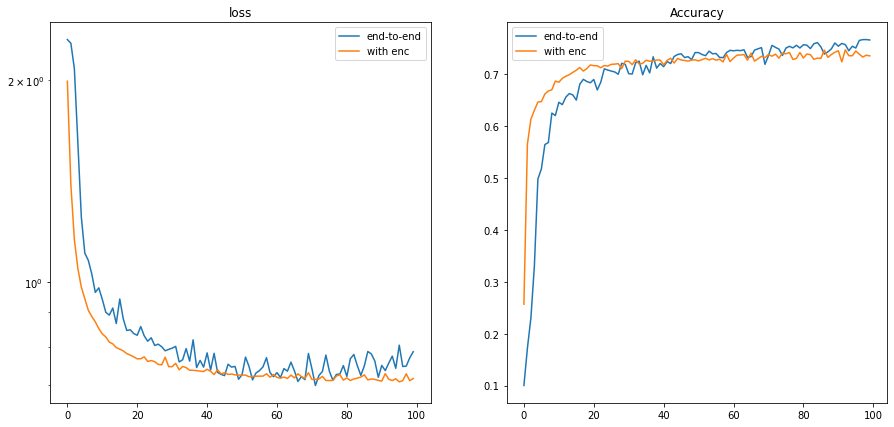

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].plot(val_losses_full, label="end-to-end")
axs[0].plot(val_losses_enc, label="with enc")
axs[0].set_yscale("log")
axs[0].set_title("loss")
axs[0].legend()

axs[1].plot(val_accs_full, label="end-to-end")
axs[1].plot(val_accs_enc, label="with enc")
axs[1].set_title("Accuracy")
axs[1].legend()

**Autoencoders** can be used to solve a variety of different tasks!


*   Denoising images: add random noise to the training transform and want to predict the denoised image
*   Filling holes: add random holes in the image and predict the filled image
*   Image Generation: via Variational Autoencoders VAEs,...

